In [135]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras import layers, losses
from tensorflow.keras.optimizers import Adam
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from enum import Enum
import PIL
import PIL.Image
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping 
from PIL import Image
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import BatchNormalization
import random

In [136]:
cnn = Sequential()
cnn.add(Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Conv2D(128, (3, 3), activation='relu'))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Conv2D(256, (3, 3), activation='relu'))
cnn.add(Flatten())
cnn.add(Dense(256, activation='relu'))
cnn.add(Dense(128 * 128, activation='sigmoid'))
cnn.add(Reshape((128, 128)))

In [137]:
class AutoencoderWithDense(Model):
    def __init__(self, latent_dim, dropout_rate=0.4):
        super(AutoencoderWithDense, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            # layers.Dense(8192, activation="relu"), # Added Dense
            # layers.Dropout(dropout_rate), 
            # layers.Dense(4096, activation="relu"), # Added Dense
            # layers.Dropout(dropout_rate), 
            layers.Dense(2048, activation="relu"), # Added Dense
            layers.Dropout(dropout_rate), 
            layers.Dense(1024, activation="relu"), # Added Dense
            layers.Dropout(dropout_rate), 
            # layers.Dense(512, activation="relu"), # Added Dense
            # layers.Dropout(dropout_rate), 
            layers.Dense(latent_dim, activation='relu'),
            ])
        self.decoder = tf.keras.Sequential([
            # layers.Dense(512, activation="relu"), # Added Dense
            # layers.Dropout(dropout_rate), 
            layers.Dense(1024, activation="relu"), # Added Dense
            layers.Dropout(dropout_rate), 
            layers.Dense(2048, activation="relu"), # Added Dense
            layers.Dropout(dropout_rate), 
            # layers.Dense(4096, activation="relu"), # Added Dense
            # layers.Dropout(dropout_rate), 
            # layers.Dense(8192, activation="relu"), # Added Dense
            layers.Dense(128 * 128, activation='sigmoid'),
            layers.Reshape((128, 128)) # is reversed from other functions
            # layers.Reshape((100, 200)) # is reversed from other functions
            ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder_with_dense = AutoencoderWithDense(latent_dim = 150)
autoencoder_with_dense.build(input_shape=(None, 128, 128, 1))
         

In [138]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = tf.keras.Sequential([
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Conv2D(256, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(256, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        ])
        self.middle = Conv2D(512, (3, 3), activation='relu', padding='same')
        self.decoder = tf.keras.Sequential([
            UpSampling2D((2,2)), 
            Conv2D(256, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(256, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            UpSampling2D((2,2)), 
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            UpSampling2D((2,2)), 
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
        ])
        self.output_layer = Conv2D(1, (1, 1), activation='sigmoid', padding='same')

    def call(self, x):
        x = tf.expand_dims(x, axis=-1)
        encoded = self.encoder(x)
        middle = self.middle(encoded)
        decoded = self.decoder(middle)
        output = self.output_layer(decoded)
        return output

unet_model = UNet()
unet_model.build(input_shape=(None, 128, 128))

In [139]:
cnn.load_weights('/Users/miranyildirim/Desktop/DIS/Neural/final/TomJerryDoodles/src/SavedModels/ObjectDetectedCNN.keras')
autoencoder_with_dense.load_weights('/Users/miranyildirim/Desktop/DIS/Neural/final/TomJerryDoodles/src/SavedModels/ObjectDetectedDense.keras')
unet_model.load_weights('/Users/miranyildirim/Desktop/DIS/Neural/final/TomJerryDoodles/src/SavedModels/ObjectDetectedU-Net.keras')

In [140]:
def loadImage(input_file_path, output_file_path, image_shape=(400, 200), isRGB = True): 
    input_image = Image.open(input_file_path).resize(image_shape)
    output_image = Image.open(output_file_path).resize(image_shape)
    beforeGrayScale = np.array(input_image)
   
    if not isRGB: 
        input_image = input_image.convert("L")
        output_image = output_image.convert("L")

    return np.array(input_image)/118.0, np.array(output_image)/255.0


In [154]:
personal_image_shape = (128, 128)

filenames_tom = ["tom840.jpg", "tom1246.jpg"]
filenames_jerry = ["jerry59.jpg", "jerry103.jpg"]

inputImageBasepathTom = r'/Users/miranyildirim/Desktop/DIS/Neural/final/TomJerryDoodles/images_to_display/tom object detected edge/' 
outputImageBasepathTom = r'/Users/miranyildirim/Desktop/DIS/Neural/final/TomJerryDoodles/images_to_display/tom object detected/'

inputImageBasepathJerry = r'/Users/miranyildirim/Desktop/DIS/Neural/final/TomJerryDoodles/images_to_display/jerry object detected edge/'
outputImageBasepathJerry = r'/Users/miranyildirim/Desktop/DIS/Neural/final/TomJerryDoodles/images_to_display/jerry object detected/'

inputImages = []
outputImages = []

for filename in filenames_tom:
    inputImagePathTom = f"{inputImageBasepathTom}{filename}"
    outputImagePathTom = f"{outputImageBasepathTom}{filename}"
    inputImageTom, imageLabelTom = loadImage(inputImagePathTom, outputImagePathTom, personal_image_shape, isRGB=False)
    inputImages.append(inputImageTom)
    outputImages.append(imageLabelTom)

for filename in filenames_jerry:
    inputImagePathJerry = f"{inputImageBasepathJerry}{filename}"
    outputImagePathJerry = f"{outputImageBasepathJerry}{filename}"
    inputImageJerry, imageLabelJerry = loadImage(inputImagePathJerry, outputImagePathJerry, personal_image_shape, isRGB=False)
    inputImages.append(inputImageJerry) 
    outputImages.append(imageLabelJerry)

inputImagesArray = np.array(inputImages)
outputImagesArray = np.array(outputImages)

In [155]:
print("Input Images Shape:", inputImagesArray.shape)
print("Output Images Shape:", outputImagesArray.shape)

Input Images Shape: (4, 128, 128)
Output Images Shape: (4, 128, 128)


In [156]:
cnn_model_output = cnn.predict(np.array(inputImagesArray))
dense_model_output = autoencoder_with_dense.predict(np.array(inputImagesArray))
unet_model_output = unet_model.predict(np.array(inputImagesArray))

1/1 [==============================] - 0s 242ms/step


In [157]:
def display_images(edge_filtered, cnn_output, dense_output, unet_model_output, ground_truth):
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 5, 1)
    plt.imshow(edge_filtered, cmap='gray') 
    plt.title('Edge Filtered')
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(ground_truth, cmap='gray')  
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(cnn_output, cmap='gray')  
    plt.title('CNN Output')
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(dense_output, cmap='gray') 
    plt.title('Dense Model Output')
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow(unet_model_output, cmap='gray')
    plt.title('U-Net Model Output')
    plt.axis('off')

    plt.show()


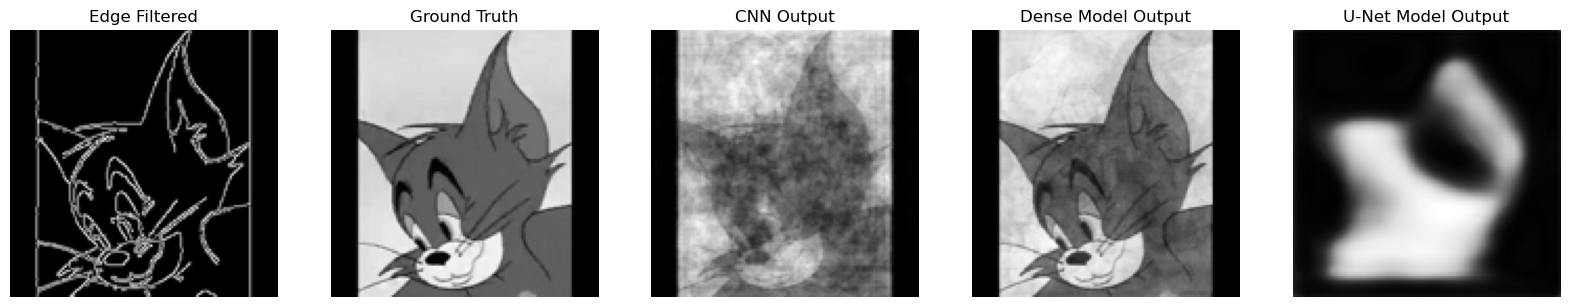

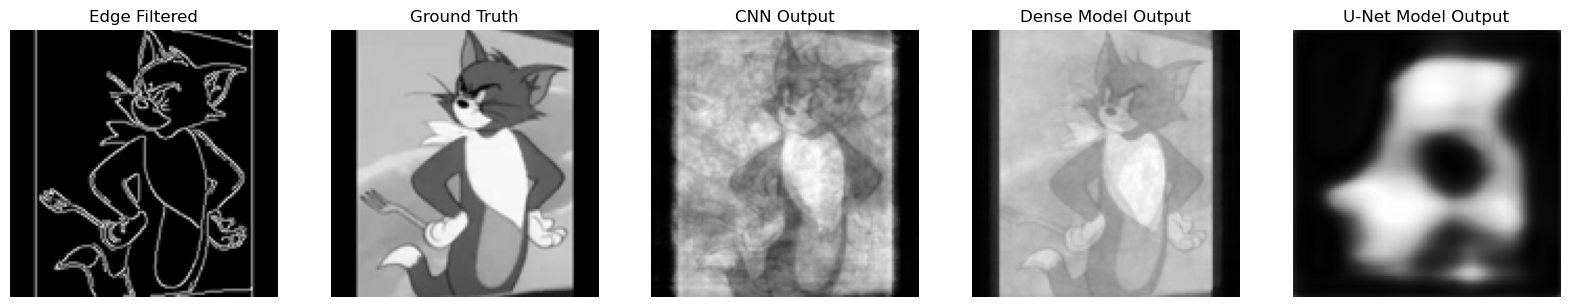

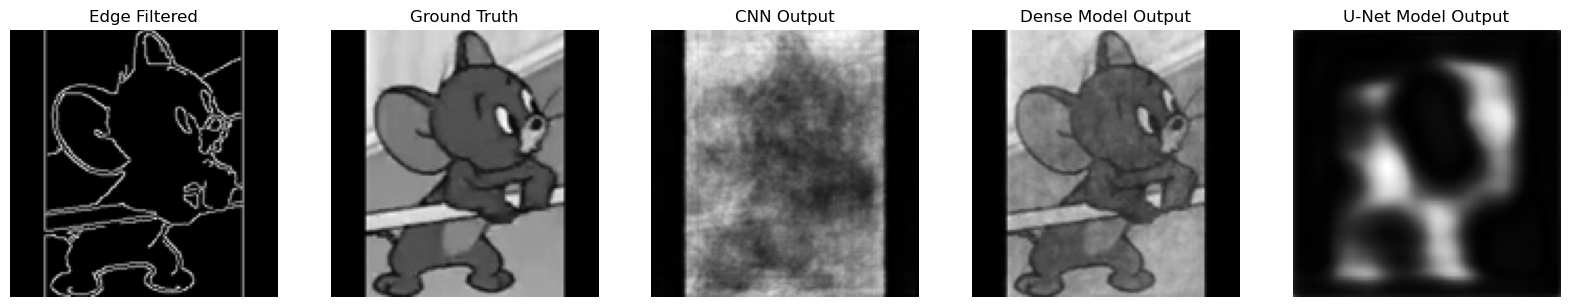

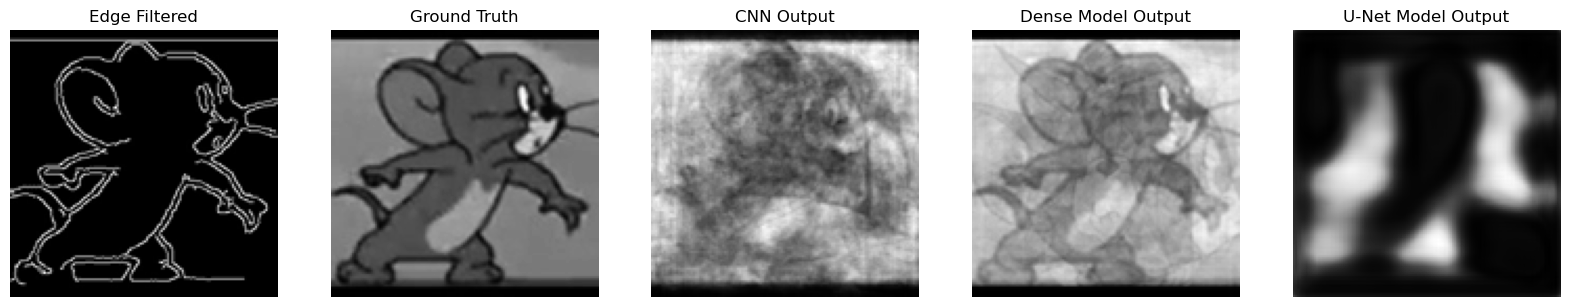

In [158]:
for i in range(len(inputImagesArray)):
    display_images(inputImagesArray[i], cnn_model_output[i], dense_model_output[i], unet_model_output[i], outputImagesArray[i])

In [159]:
# code found from: https://note.nkmk.me/en/python-pillow-add-margin-expand-canvas/
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result
PIL.ImageFile.LOAD_TRUNCATED_IMAGES = True

In [164]:
imageNamesTom = os.listdir("/Users/miranyildirim/Desktop/DIS/Neural/final/TomJerryDoodles/images_to_display/handdrawn/tom_edge_detected")
imageNamesJerry = os.listdir("/Users/miranyildirim/Desktop/DIS/Neural/final/TomJerryDoodles/images_to_display/handdrawn/jerry_edge_detected")

handdrawnImages = []
handdrawnOriginal = []

apply_threshold = True

for imageName in imageNamesTom: 
    image = Image.open(f"/Users/miranyildirim/Desktop/DIS/Neural/final/TomJerryDoodles/images_to_display/handdrawn/tom_edge_detected/{imageName}")
    image = expand2square(image, (0,0,0))
    image = image.resize((128, 128))
    image = image.convert("L")
    image = np.array(image)

    maxNum= float("-inf")

    if apply_threshold:
        for i in range(len(image)): 
            for j in range(len(image[0])): 
                    if image[i][j] > maxNum: 
                        maxNum = image[i][j]
                    if image[i][j] > 12: 
                        image[i][j] = 1.0
                    else: 
                        image[i][j] = 0.0

    # plt.figure(figsize=(12, 6))
    # plt.imshow(image)
    # plt.show()
    handdrawnImages.append(np.array(image))

for imageName in imageNamesJerry: 
    image = Image.open(f"/Users/miranyildirim/Desktop/DIS/Neural/final/TomJerryDoodles/images_to_display/handdrawn/jerry_edge_detected/{imageName}")
    image = expand2square(image, (0,0,0))
    image = image.resize((128, 128))
    image = image.convert("L")
    image = np.array(image)

    maxNum= float("-inf")

    if apply_threshold:
        for i in range(len(image)): 
            for j in range(len(image[0])): 
                if image[i][j] > maxNum: 
                    maxNum = image[i][j]
                if image[i][j] > 12: 
                    image[i][j] = 1.0
                else: 
                    image[i][j] = 0.0

    # plt.figure(figsize=(12, 6))
    # plt.imshow(image)
    # plt.show()
    handdrawnImages.append(np.array(image))


for imageName in imageNamesTom:
    image = Image.open(f"/Users/miranyildirim/Desktop/DIS/Neural/final/TomJerryDoodles/images_to_display/handdrawn/tom/{imageName}")
    image = expand2square(image, (0,0,0))
    image = image.resize((128, 128))
    image = image.convert("L")
    image = np.array(image)
    handdrawnOriginal.append(image)


for imageName in imageNamesJerry:
    image = Image.open(f"/Users/miranyildirim/Desktop/DIS/Neural/final/TomJerryDoodles/images_to_display/handdrawn/jerry/{imageName}")
    image = expand2square(image, (0,0,0))
    image = image.resize((128, 128))
    image = image.convert("L")
    image = np.array(image)
    handdrawnOriginal.append(image)


handdrawnImages = np.array(handdrawnImages)

In [165]:
cnn_model_output = cnn.predict(handdrawnImages)
dense_model_output = autoencoder_with_dense.predict(handdrawnImages)
unet_model_output = unet_model.predict(handdrawnImages)

1/1 [==============================] - 0s 471ms/step


In [166]:
def display_images_handrawn(edge_filtered, ground_truth, cnn_output, dense_output, unet_model_output):
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 5, 1)
    plt.imshow(edge_filtered, cmap='gray') 
    plt.title('Edge Filtered')
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(ground_truth, cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(cnn_output, cmap='gray')  
    plt.title('CNN Output')
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(dense_output, cmap='gray') 
    plt.title('Dense Model Output')
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow(unet_model_output, cmap='gray')
    plt.title('U-Net Model Output')
    plt.axis('off')

    plt.show()


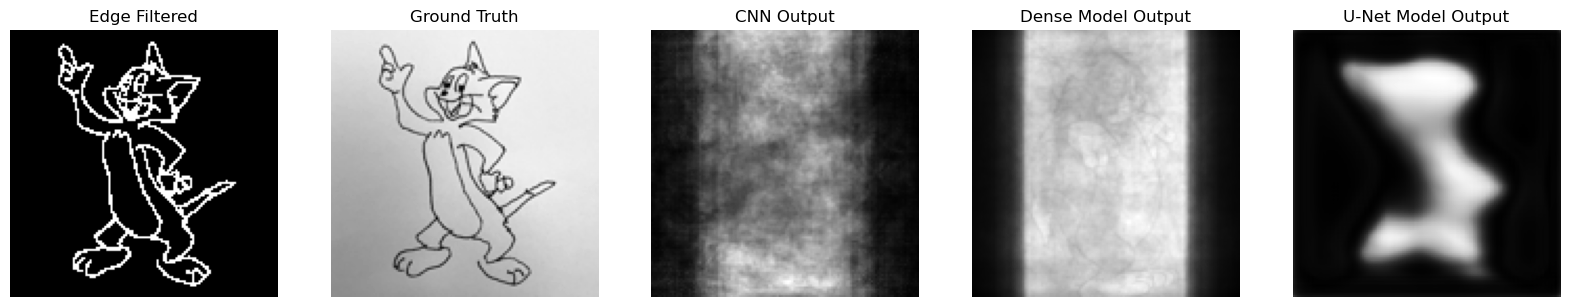

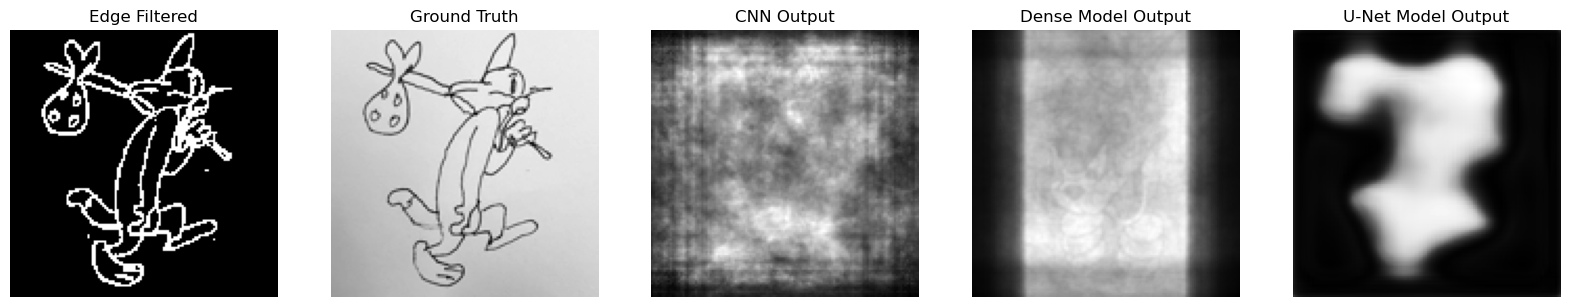

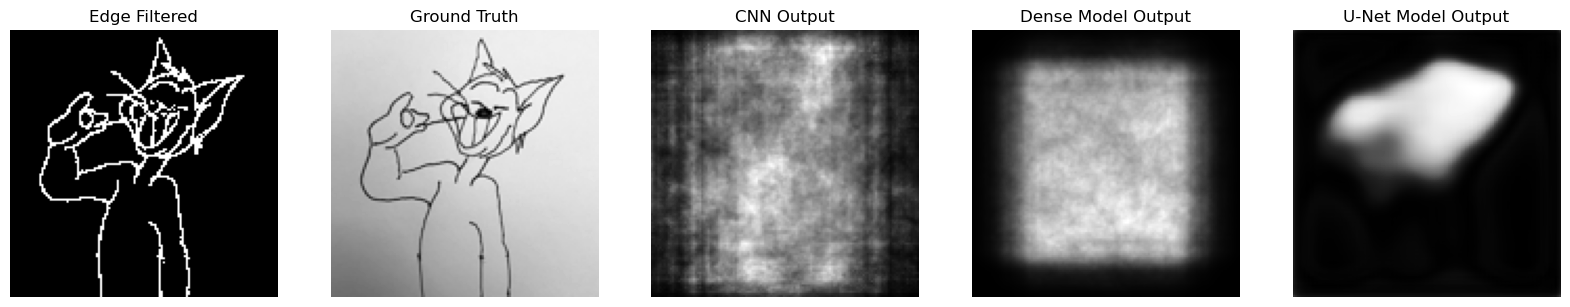

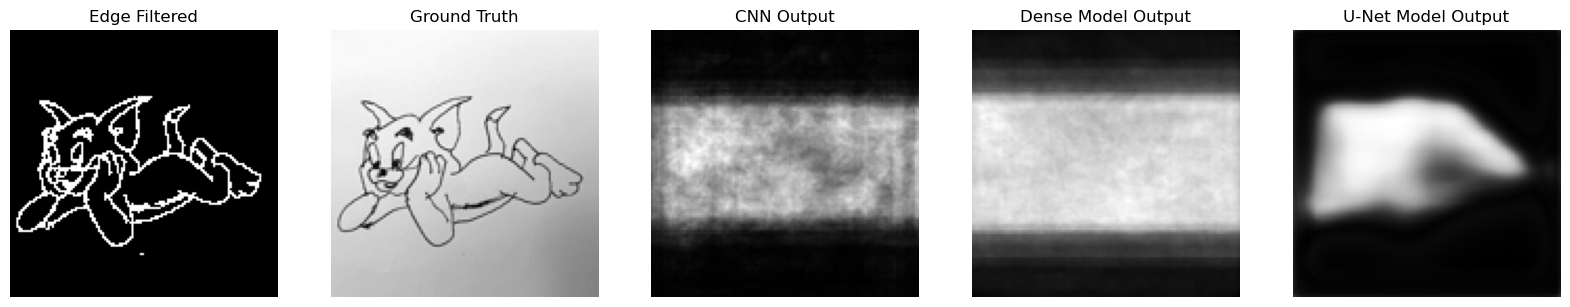

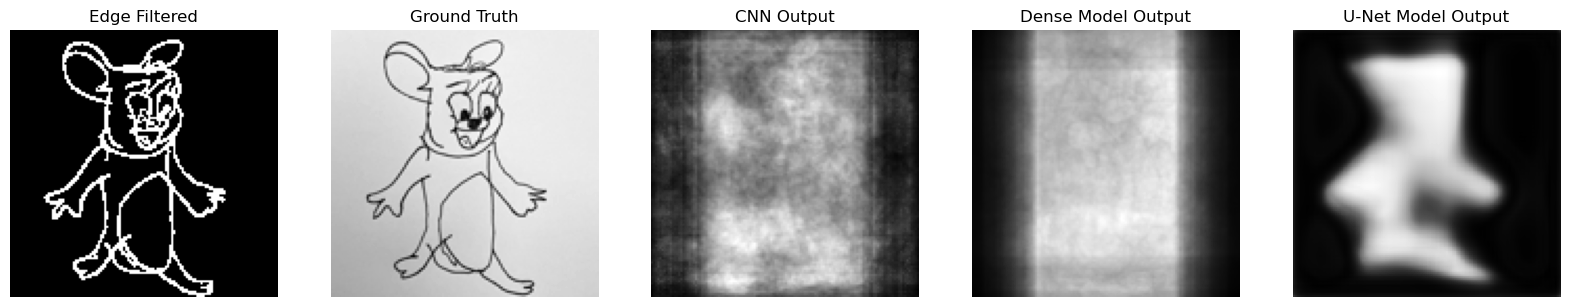

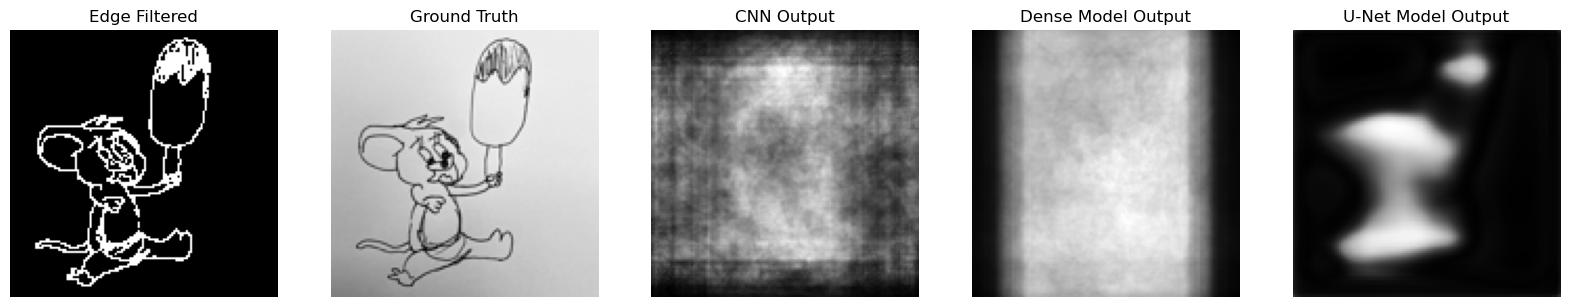

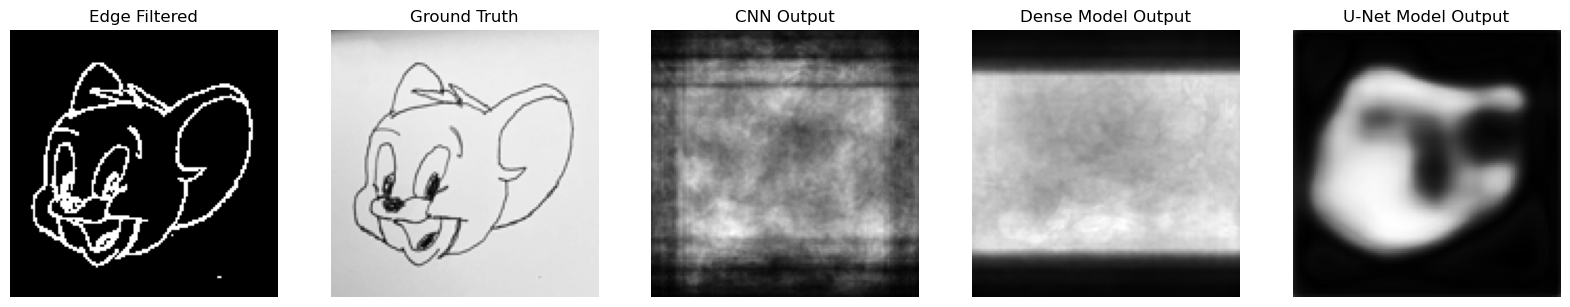

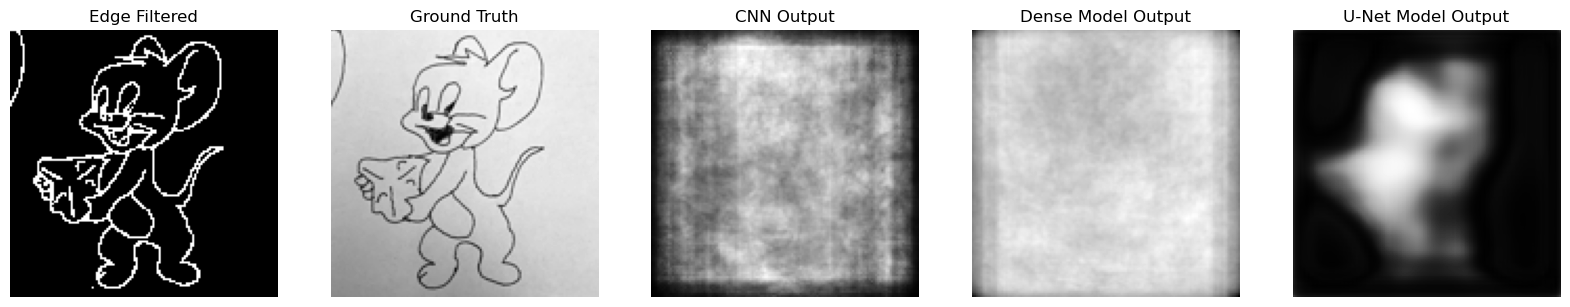

In [167]:
for i in range(len(handdrawnImages)):
    display_images_handrawn(handdrawnImages[i], handdrawnOriginal[i], cnn_model_output[i], dense_model_output[i], unet_model_output[i])